<h1 style="text-align:center;font-size:30px;" >Authentifake</h1>

#### @CITE : https://towardsdatascience.com/image-forgery-detection-2ee6f1a65442  
#### Inspired by the work of Vishal Singh

###  1.1 Download dataset

In [2]:
# from ibm_botocore.client import Config
# import ibm_boto3

# cos = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id=credentials['IBM_API_KEY_ID'],
#     ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
#     ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
#     config=Config(signature_version='oauth'),
#     endpoint_url=credentials['ENDPOINT'])

In [3]:
# cos.download_file(Bucket=credentials['BUCKET'],Key='phase-01-training.tar.gz',Filename='phase-01-training.tar.gz')

In [2]:
import tarfile

tar = tarfile.open("phase-01-training.tar.gz", "r:gz")
tar.extractall()
tar.close()

In [102]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
from imageio import imread
import shutil
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import sys
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import cv2
%matplotlib inline

<h3> 2.1.1 Data Overview </h3>

Data is made available as a tar file which when unzipped gives a folder dataset-dist.<br> 
dataset-dist/phase-01/training has 2 folders
- fake : containing all fake images along with associated masks
- pristine : containing all pristine images

In [5]:
print('Number of fake images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/fake'))-1)/2))

Number of fake images = 450.0


In [6]:
print('Number of pristine images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/pristine/')))))

Number of pristine images = 1050


<h3> 2.1.2 Example fake image </h3>

In [7]:
arr= imread('dataset-dist/phase-01/training/fake/'+'092b43f88eab0ae3ecc0eb0ccbe37c82.png')

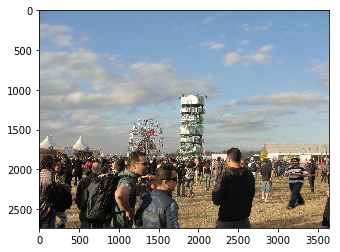

In [8]:
plt.imshow(arr)

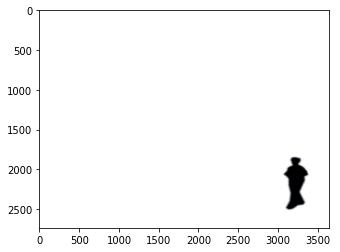

In [9]:
# Mask applied
arr=imread('dataset-dist/phase-01/training/fake/'+'092b43f88eab0ae3ecc0eb0ccbe37c82.mask.png')
plt.imshow(arr)

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given image need to predict if it is fake or not. </p>

<h2> 3.1. Number of images </h2>

In [10]:
print('Number of fake images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/fake/'))-1)/2)) # the folder contains both fake image and its mask
print('Number of pristine images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/pristine/')))))

Number of fake images = 450.0
Number of pristine images = 1050


<h2> 3.2. Image shape </h2>

In [11]:
fake_path = 'dataset-dist/phase-01/training/fake/'
pristine_path = 'dataset-dist/phase-01/training/pristine/'
mask_path = 'dataset-dist/phase-01/training/'

# remove .ds_store

In [12]:
import os        
def delete_dstore(items,items_path):
    for item in items:
        if item == ".DS_Store":
#             print(item)
            os.remove(os.path.join(items_path, item))

In [13]:
fakes = os.listdir(fake_path)[1:]
pristines = os.listdir(pristine_path)

delete_dstore(fakes,fake_path)
#print(delete_dstore(fakes,fake_path))
# print(delete_dstore(pristines,pristine_path))

In [14]:
fakes = os.listdir(fake_path)[1:]
pristines = os.listdir(pristine_path)[1:]

In [15]:
".DS_Store" in fakes

False

In [16]:

for f in fakes:
    if f.endswith(".DS_Store"):
        print(f)
#         fakes.remove(".DS_Store")
        
        
for p in pristines:
    if p.endswith(".DS_Store"):
        print(p)
#         pristines.remove(".DS_Store")

In [17]:
fakes[:10] # mask followed by image

['b835388bf7843d20544c6de90d11c51c.png',
 'eded2f92d413246c29001c448dbddd1b.mask.png',
 'a607a69c1d589cf0e9d24ff6162abf01.mask.png',
 'bedffe5f780e3c2be2cc032450ce0800.mask.png',
 'b73fef9b8686be108f9deec80e8ed880.png',
 '87238ad60578291fff62151eb6618adb.mask.png',
 'c2e9e25b3f224a2bc80ca1f6dd86f465.mask.png',
 'b9988711e0a2880bb4fa8cf549dc55bc.mask.png',
 'c6b5dc9a4db605cdc15a51d4bd6cb228.mask.png',
 '660234fb74717f1874bf604b7d3e3818.mask.png']

In [18]:
pristines[:10]

['5a2c17fb2299adfb232fb5c99b48afbc.png',
 '4d8bc44bbb81455841f76a4e2fe71224.png',
 '0ba8a5777136acae9e46cf63aa50dc10.png',
 '0ace39e0605d72d7ff1ac92a28422f2a.png',
 '00fbcae4d05aeab62ab917e587b911f9.png',
 '5ce553d99d488a214004a0c2a8298d2a.png',
 '2e5c14b7e5532c2f1a067c6327d79714.png',
 '0bf7b1f315d2e537e101e8ea09707cdd.png',
 '2d2c4cc2cbab10b0e900675d680a2e17.png',
 '7a1a647827c6bfb1b14968a37e7010b9.png']

In [19]:
# segregate masks from images
#create mask folder under fake folder

# if not os.path.isdir(fake_path+'masks/'):
#     os.mkdir(fake_path+'masks/')
#     for fake in fakes:
#         if len(fake.split('.'))==3:
#             shutil.move(fake_path+fake, fake_path+'masks/')
# else:
#     print('Segregated already')


if not os.path.isdir(mask_path+'masks/'):
    os.mkdir(mask_path+'masks/')
    for fake in fakes:
        if len(fake.split('.'))==3:
            shutil.move(fake_path+fake, mask_path+'masks/')
else:
    print('Segregated already')

In [23]:
# shutil.rmtree(fake_path+'masks/')
# print(os.listdir(fake_path+'masks/')[1:-1])

<h2> 3.2. Image shape fake images</h2>

In [20]:
fakes = os.listdir(fake_path)[1:-1]
print(fakes)

['b835388bf7843d20544c6de90d11c51c.png', 'b73fef9b8686be108f9deec80e8ed880.png', 'e025b80af56ce319d0a02bd97a086768.png', 'ab174fdf91d7381d1f891f93a493ab4c.png', 'b1fb2e2690c484ef7b0a75698150ed27.png', 'cbf35bfeb900387380e043ef4523ed7a.png', 'a470313562508266ecf17a4a5410fc6f.png', 'b37a15fd949a331a8aca247b7ca34f2d.png', 'c01eb038f84397e1116a56414e16fcee.png', 'c6216855a09754f487980c889f7a8732.png', 'a1cf0d7ad91ea76248214c165e9491c5.png', 'c78759a7396dd709da30a25683b6219c.png', 'cdce0701fa96db632af5facf074fe654.png', 'e8540972740aa21638731940c3bebe42.png', 'bd993ecb7172acc9508e2d74fa239e6c.png', 'c6e38b5fcc7d77df53dd101605d68b92.png', 'f95d94a3a6384059a64725f89677e885.png', 'b42396107373446a2ab013cd61460b04.png', 'a570fb86a76eefb5d38a74d029415770.png', 'd9be92214b9b151afa53a2debdd6acc6.png', 'b46af5d99d6fd9a7f80bbfb43b220bbb.png', 'b0e304ca50739b4bb48620960a4006b9.png', 'dbe57dd8b2e7b7349a37705965bc889f.png', '966360f61a4e1d058f71002b43136b60.png', 'aa2195acc0c17507e356e60955e30638.png',

In [25]:
# fakes = []
# for fake in fakes1:
#     if fake != ".DS_Store":
#         fakes.append(fake)

In [26]:
# #all_fakes
# import glob
# all_fakes = glob.glob(fake_path + "*.png")
# #print(all_fakes) 
# for fake in fakes:
#     fake_shapes.append(imread(fake_path+fake).shape)

In [21]:
fakes

['b835388bf7843d20544c6de90d11c51c.png',
 'b73fef9b8686be108f9deec80e8ed880.png',
 'e025b80af56ce319d0a02bd97a086768.png',
 'ab174fdf91d7381d1f891f93a493ab4c.png',
 'b1fb2e2690c484ef7b0a75698150ed27.png',
 'cbf35bfeb900387380e043ef4523ed7a.png',
 'a470313562508266ecf17a4a5410fc6f.png',
 'b37a15fd949a331a8aca247b7ca34f2d.png',
 'c01eb038f84397e1116a56414e16fcee.png',
 'c6216855a09754f487980c889f7a8732.png',
 'a1cf0d7ad91ea76248214c165e9491c5.png',
 'c78759a7396dd709da30a25683b6219c.png',
 'cdce0701fa96db632af5facf074fe654.png',
 'e8540972740aa21638731940c3bebe42.png',
 'bd993ecb7172acc9508e2d74fa239e6c.png',
 'c6e38b5fcc7d77df53dd101605d68b92.png',
 'f95d94a3a6384059a64725f89677e885.png',
 'b42396107373446a2ab013cd61460b04.png',
 'a570fb86a76eefb5d38a74d029415770.png',
 'd9be92214b9b151afa53a2debdd6acc6.png',
 'b46af5d99d6fd9a7f80bbfb43b220bbb.png',
 'b0e304ca50739b4bb48620960a4006b9.png',
 'dbe57dd8b2e7b7349a37705965bc889f.png',
 '966360f61a4e1d058f71002b43136b60.png',
 'aa2195acc0c175

In [22]:
fake_shapes=[]                      
for fake in fakes:
    fake_shapes.append(imread(fake_path+fake).shape)

In [23]:
for i in range(20):
    ind=np.random.randint(0, len(fake_shapes))
    print(str(ind) +'\t'+ str(fake_shapes[ind]) +'\t'+fakes[ind])

251	(3000, 4000, 3)	371e6f86e51ab2258b69547dd7657b30.png
78	(768, 1024, 3)	b9c5470e3233747c69d951707fc0caa1.png
57	(771, 1024, 3)	cb4d47e95b84ec3eee1796bc8fff1180.png
352	(765, 1024, 3)	813068ba4f493ad7308b4666e0afe711.png
276	(768, 1024, 3)	d918eeffd78047944ec2d97c4594eb8b.png
165	(771, 1024, 3)	c0200dcf86e0c83a600efc4029561dbd.png
445	(3240, 4320, 3)	cab8ac89fc001f1adb2ff4d8b3f9f9a9.png
54	(771, 1024, 3)	bbb6f569a59a45dd2d895eda0431b036.png
177	(768, 1024, 3)	c86cb7e7cf51b7b182a6ffa8b253ed2b.png
12	(768, 1024, 3)	cdce0701fa96db632af5facf074fe654.png
346	(3000, 4000, 3)	e6764ef0fb7a2a0b624b554c89c62137.png
399	(768, 1024, 3)	c414179415b146d9cbeca0fb3fb351a7.png
318	(2304, 3072, 3)	b8cecf240477353bdf87aac6521e066f.png
116	(900, 1600, 3)	e81d4326a9aba0df4346edaf4e64c0d0.png
390	(768, 1024, 4)	c9699a289977ce2d80c6e073eadf8b2a.png
206	(1200, 1600, 3)	c658e082c4a76075a2f91c731b1f79a0.png
281	(768, 1024, 3)	bd162a474c3726de6e7b9790feb95a00.png
158	(768, 1024, 3)	da69d49cc6fd90ae7a2d494009ef

Some fake images have 4 channels

In [24]:
for fake in fakes:
    if fake.endswith('.png'):
        if imread(fake_path+fake).shape[2]>4:
            print('5 channels in image ' + fake)

In [25]:
for fake in fakes:
    if imread(fake_path+fake).shape[2]<3:
        print('Less than 3 channels in image ' + fake)

In [26]:
for fake in fakes:
    if len(imread(fake_path+fake).shape)<=2:
        print(fake)

All images have 4 or 3 channels

In [27]:
four_channel_fakes=[]
for fake in fakes:
    if imread(fake_path+fake).shape[2]==4:
        four_channel_fakes.append(fake)
        
three_channel_fakes = [f for f in fakes if f not in four_channel_fakes]

In [39]:
len(four_channel_fakes)
####

64

In [40]:
len(three_channel_fakes)

384

In [30]:
heights=[]
widths=[]

for fake in fakes:
    img=imread(fake_path+fake)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

In [41]:
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 480
maximum height = 4288
minimum width = 640
maximum width = 4320


<h2> 3.3. Image shape masks</h2>

In [42]:
mask_path1 = mask_path + 'masks/'

In [43]:
masks = os.listdir(mask_path1)

In [45]:
masks

['eded2f92d413246c29001c448dbddd1b.mask.png',
 'a607a69c1d589cf0e9d24ff6162abf01.mask.png',
 'bedffe5f780e3c2be2cc032450ce0800.mask.png',
 '87238ad60578291fff62151eb6618adb.mask.png',
 'c2e9e25b3f224a2bc80ca1f6dd86f465.mask.png',
 'b9988711e0a2880bb4fa8cf549dc55bc.mask.png',
 'c6b5dc9a4db605cdc15a51d4bd6cb228.mask.png',
 '660234fb74717f1874bf604b7d3e3818.mask.png',
 'b46af5d99d6fd9a7f80bbfb43b220bbb.mask.png',
 'b81643f10ef2075412532d13eb274b1e.mask.png',
 'aa62ae56c20735351461f141d4ede330.mask.png',
 '44061b655cd1191b0f0e8a19a0e7e69d.mask.png',
 'd09aedf8c4f0622413bf67f8e5715bcf.mask.png',
 '839128f5837a4d3614e9f1f6b4cf087e.mask.png',
 '244a7433a307b9a2c839cefe14c0ba1d.mask.png',
 '8812398ed09ccb906f4e0d608aec0913.mask.png',
 'b9b5386221a626f791fdd6cf400b73df.mask.png',
 'd90d1935c16712717b15cb9d29a2dd9f.mask.png',
 'f0d05a2fce59b068846bd1c8453d7d89.mask.png',
 '364f0d4ece36860de6c2ad8cf943b800.mask.png',
 '7125cec169f3635cd07db90b16e848d5.mask.png',
 '2508f9cfb3c5f96d4539dcb1fa049d6a

In [46]:
mask_shapes=[]
for mask in masks:
    mask_shapes.append(imread(mask_path1+mask).shape)

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [47]:
for i in range(20):
    ind=np.random.randint(0, len(mask_shapes))
    print(str(ind) +'\t'+ str(mask_shapes[ind]) +'\t'+masks[ind])

281	(768, 1024)	734143eea107a2b53235e9ff8d43cfdc.mask.png
107	(768, 1024)	bd2dc6a591234f7855101bb3e66c96c8.mask.png
237	(768, 1024)	d52264908b734ce04d2f4da2a07f531d.mask.png
358	(768, 1024)	7359205ed162a1f63a4537be468f9a71.mask.png
337	(768, 1024)	d507e807f025f09ea0cff40b52e9322c.mask.png
172	(768, 1024)	ceb9fcd4486cd56c04bf66804cfee9f0.mask.png
346	(768, 1024)	d64f0d1c4c3e893b1d0f3aa5b9967830.mask.png
137	(771, 1024)	b815a74cfdca7f5da57fc1b0687f89cd.mask.png
167	(768, 1024)	acd862c22c84f9f4f22a665573c0dc9c.mask.png
135	(3240, 4320, 3)	fce1efb32a85a7f67f959a7c37f1f52b.mask.png
59	(768, 1024)	d7907191ca56c0adca3df658743028e3.mask.png
285	(806, 1075)	d9be92214b9b151afa53a2debdd6acc6.mask.png
42	(768, 1024)	ab1e91e9a308f42d3cd0baa59f7c7c71.mask.png
380	(768, 1024)	b835388bf7843d20544c6de90d11c51c.mask.png
444	(3216, 4288, 3)	2744a9427d865323a62eff7fdfbb9ed5.mask.png
10	(768, 1024)	aa62ae56c20735351461f141d4ede330.mask.png
422	(1000, 1504)	e3137a7b21d07b4daa8a23cf778cc083.mask.png
160	(768

In [50]:
for mask in masks:
    img=imread(mask_path1+mask)
    if len(img.shape)>2 and img.shape[2]>4:
        print('More than 4 channels in image ' + mask)

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [51]:
for mask in masks:
    img=imread(mask_path1+mask)
    if len(img.shape)>2 and img.shape[2]<3:
        print('Less than 3 channels in image ' + mask)

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [53]:
one_channel_masks=[]
for mask in masks:
    if len(imread(mask_path1+mask).shape)==2:
        one_channel_masks.append(mask)

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [54]:
three_channel_masks=[]
for mask in masks:
    img=imread(mask_path1+mask)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_masks.append(mask)

four_channel_masks=[m for m in masks if ((m not in one_channel_masks) and (m not in three_channel_masks))]

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [55]:
len(three_channel_masks)

65

In [56]:
len(four_channel_masks)

55

In [57]:
print(str(len(one_channel_masks))+' masks have only one channel i.e. grayscale')

330 masks have only one channel i.e. grayscale


All masks have 1, 3 or 4 channels

In [58]:
heights=[]
widths=[]

for mask in masks:
    img=imread(mask_path1+mask)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


minimum height = 480
maximum height = 4288
minimum width = 640
maximum width = 4320


In [59]:
i=0
for mask, fake in tqdm_notebook(zip(masks, fakes)):
    mask_img=imread(mask_path1+mask)
    fake_img=imread(fake_path+fake)
    if mask_img.shape[:2]!=fake_img.shape[:2]:
        i+=1
        print(str(mask_img.shape)+' '+str(fake_img.shape))

(1944, 2592, 3) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(768, 1024) (1188, 792, 3)
(1536, 2048, 4) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(768, 1024) (1200, 1600, 3)
(768, 1024) (806, 1075, 3)
(600, 800, 4) (765, 1024, 3)
(1536, 2048, 4) (691, 922, 3)
(1637, 2352, 4) (768, 1024, 3)
(768, 1024) (1200, 1600, 3)
(765, 1024) (1536, 2048, 4)
(1152, 1536) (768, 1024, 3)
(2304, 3072, 3) (806, 1075, 3)
(3240, 4320, 3) (768, 1024, 3)
(1200, 1600, 3) (768, 1024, 3)
(771, 1024) (1072, 1424, 3)
(2758, 4150, 4) (768, 1024, 3)
(600, 800, 4) (768, 1024, 3)
(771, 1024) (768, 1024, 4)
(768, 1024) (1024, 768, 4)
(765, 1024) (768, 1024, 3)
(771, 1024) (768, 1024, 3)
(3240, 4320, 3) (768, 1024, 3)
(2144, 2848, 3) (768, 1024, 3)
(768, 1024) (3216, 4288, 3)
(2736, 3648, 3) (768, 1024, 3)
(768, 1024) (972, 1296, 3)
(768, 1024) (1944, 2592, 3)
(1536, 2048, 4) (768, 1024, 3)
(768, 1024) (806, 1075, 3)
(598, 848, 3) (768, 1024, 3)
(768, 1024) (765, 1024, 3)
(771, 1024) (768, 1024, 3)
(771, 1024) (7

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


(768, 1024) (1936, 2592, 3)
(768, 1024) (2112, 2816, 3)
(1536, 2048, 4) (768, 1024, 3)
(765, 1024) (768, 1024, 3)
(598, 848, 3) (1536, 2048, 3)
(768, 1024) (1536, 2048, 4)
(3000, 4000, 3) (768, 1024, 3)
(771, 1024) (768, 1024, 3)
(3240, 4320, 3) (1536, 2048, 3)
(768, 1024) (1152, 1536, 3)
(1536, 2048, 4) (600, 800, 4)
(3240, 4320, 3) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(768, 1024) (771, 1024, 3)
(768, 1024) (765, 1024, 3)
(768, 1024) (3240, 4320, 3)
(3240, 4320, 3) (2976, 3968, 3)
(768, 1024) (2736, 3648, 3)
(768, 1024) (3240, 4320, 3)
(1536, 2048, 3) (768, 1024, 3)
(2736, 3648, 3) (768, 1024, 3)
(648, 1152) (570, 760, 4)
(768, 1024) (1109, 1663, 3)
(3000, 4000, 3) (768, 1024, 3)
(806, 1075) (3000, 4000, 3)
(768, 1024) (1920, 2560, 3)
(480, 640, 4) (768, 1024, 3)
(768, 1024) (3240, 4320, 3)
(2748, 3664, 3) (768, 1024, 3)
(768, 1024) (771, 1024, 3)
(1067, 1600) (1536, 2048, 4)
(720, 960) (1067, 1600, 3)
(1152, 1536) (768, 1024, 3)
(2048, 1536, 4) (768, 1024, 3)
(3240, 4320, 3)

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


(933, 1600, 4) (768, 1024, 3)
(806, 1075) (1536, 2048, 4)
(720, 960) (2758, 4150, 4)
(3216, 4288, 3) (1200, 1600, 3)
(768, 1024) (771, 1024, 3)
(768, 1024) (1536, 2048, 3)
(3000, 4000, 3) (768, 1024, 3)
(806, 1075) (768, 1024, 3)
(2144, 2848, 3) (768, 1024, 3)
(1944, 2592, 3) (771, 1024, 3)
(768, 1024) (3000, 4000, 3)
(768, 1024) (771, 1024, 3)
(768, 1024) (771, 1024, 3)
(1536, 2048, 4) (768, 1024, 4)
(1536, 2048, 4) (768, 1024, 3)
(768, 1024) (765, 1024, 3)
(771, 1024) (3240, 4320, 3)
(900, 1600) (768, 1024, 3)
(768, 1024) (4288, 3216, 3)
(768, 1024) (771, 1024, 3)
(2112, 2816, 3) (768, 1024, 3)
(768, 1024) (3240, 4320, 3)
(771, 1024) (768, 1024, 3)
(1109, 1663) (768, 1024, 3)
(768, 1024) (994, 1680, 4)
(1200, 1600) (768, 1024, 3)


/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


(768, 1024) (2748, 3664, 3)
(768, 1024) (1536, 2048, 3)
(771, 1024) (768, 1024, 3)
(768, 1024) (1536, 2048, 4)
(1536, 2048, 4) (768, 1024, 4)
(765, 1024) (768, 1024, 3)
(1188, 792) (806, 1075, 3)
(768, 1024) (765, 1024, 3)
(1936, 2592, 3) (2048, 1536, 3)
(768, 1024) (3240, 4320, 3)
(771, 1024) (3240, 4320, 3)
(768, 1024) (720, 960, 3)
(2304, 3072, 3) (768, 1024, 3)
(3240, 4320, 3) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(768, 1024) (778, 1037, 3)
(768, 1024) (480, 640, 4)
(1536, 2048, 4) (768, 1024, 3)
(806, 1075) (768, 1024, 3)
(3000, 4000, 3) (765, 1024, 3)
(1200, 1600, 3) (771, 1024, 3)
(792, 1188) (768, 1024, 3)
(768, 1024) (1067, 1600, 3)
(771, 1024) (768, 1024, 3)
(765, 1024) (960, 1280, 3)
(768, 1024) (1536, 2048, 3)
(768, 1024) (1000, 1504, 3)
(768, 1024) (778, 1037, 3)
(1536, 2048, 4) (563, 798, 4)
(2592, 1936, 3) (768, 1024, 3)
(994, 1680, 4) (768, 1024, 3)
(598, 848, 3) (600, 800, 4)
(1200, 1600, 3) (3000, 4000, 3)
(3240, 4320, 3) (1536, 2048, 3)
(1000, 1504) (768, 102

<h2> 3.3. Image shape pristines</h2>

In [60]:
pristine_shapes=[]
for pristine in pristines:
    pristine_shapes.append(imread(pristine_path+pristine).shape)

In [61]:
for i in range(20):
    ind=np.random.randint(0, len(pristine_shapes))
    print(str(ind) +'\t'+ str(pristine_shapes[ind]) +'\t'+pristines[ind])

77	(768, 1024, 3)	3a643c3a8cc8d66d83d4b3c3fcb8b18d.png
636	(768, 1024, 3)	0f68b5903eb36be82019631a333c9141.png
820	(768, 1024, 3)	06a16145aee6965f3008ce149c119bf6.png
1015	(575, 1024, 3)	5dea5d688f0ef0b8192fcaf27dc7e562.png
43	(680, 1024, 3)	3a13e041e01f6567262b899b5f2c5b9c.png
553	(680, 1024, 3)	6aac18ba35542f2a9fd6d91d7e202549.png
863	(768, 1020, 3)	0fed3a3ad1f24f312b4f2a2a07e30597.png
717	(768, 1024, 3)	0a3006b3036b248b12e79bae44802ec3.png
718	(768, 1024, 3)	7a58f23c07cf45256f308b5723af9f7c.png
240	(768, 1024, 3)	1bad4a292e400413353b5c9891c1339f.png
109	(768, 1024, 3)	6a5a499626b3e261fa2cb6cf15dcf59d.png
1041	(768, 1024, 3)	4b516dc276883cb0f2df8828522f072d.png
109	(768, 1024, 3)	6a5a499626b3e261fa2cb6cf15dcf59d.png
883	(768, 1024, 4)	1a1d66303c66705aed0c480852a4b7ca.png
1048	(575, 1024, 3)	1ab03120be532e415d61102e9ce30edf.png
355	(768, 1024, 3)	0ea3a3b8e12f5b4074f6dd82e2c90963.png
637	(768, 1024, 3)	2acc0576d34ddffdb12affba16ee0bfe.png
348	(768, 1024, 3)	1e0fb72cec56039d6f0343a1c395

In [62]:
three_channel_pristines=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_pristines.append(pristine)

In [63]:
one_channel_pristines=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    if len(img.shape)<3:
        one_channel_pristines.append(pristine)
    
four_channel_pristines=[p for p in pristines if (p not in one_channel_pristines) and (p not in three_channel_pristines)]

In [64]:
len(one_channel_pristines)

3

In [65]:
for pristine in one_channel_pristines:
    img=imread(pristine_path+pristine)
    print(img.shape)

(768, 1024)
(768, 1024)
(768, 1024)


In [66]:
len(three_channel_pristines)

1024

In [67]:
len(four_channel_pristines)

22

In [69]:
table={}
table['pristines']=[3, 1025, 22, 1050]
table['fakes']=[0, 386, 64, 450]
table['masks']=[330, 65, 55, 450]
pd.DataFrame(table, index=['1 channel', '3 channel', '4 channel', 'total'])

pristines  fakes  masks
1 channel          3      0    330
3 channel       1025    386     65
4 channel         22     64     55
total           1050    450    450

In [68]:
four_channel_image = imread(pristine_path+four_channel_pristines[21])

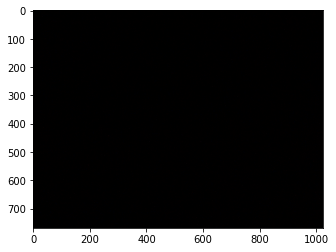

In [70]:
plt.imshow(four_channel_image)

## Only use 3 channel pristines, discard 1 and 4 channel images

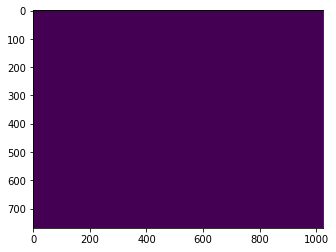

In [71]:
four_channel_image = imread(fake_path+four_channel_fakes[49])
plt.imshow(four_channel_image[:,:,3])

#####

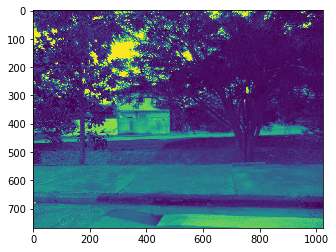

In [72]:
plt.imshow(four_channel_image[:,:,2])

Discard channel 4 of fake images with 4 channels

In [73]:
four_channel_image = imread(mask_path1+four_channel_masks[54])

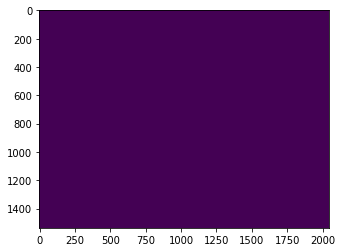

In [74]:
plt.imshow(four_channel_image[:,:,3])

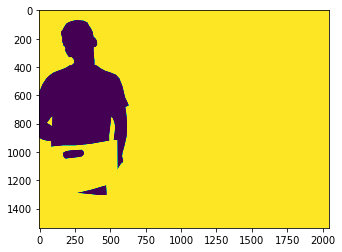

In [75]:
plt.imshow(four_channel_image[:,:,2])

Discard channel 4 of 4 channel masks. In fact the feature engineering phase requires only one channel information. The same information is duplicated across other 2 channels

In [76]:
heights=[]
widths=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 575
maximum height = 768
minimum width = 576
maximum width = 1024


<h4>Checkpoint 1</h4>

In [77]:
with open('one_channel_pristines.pickle', 'wb') as f:
    pickle.dump(one_channel_pristines, f)
    
with open('three_channel_pristines.pickle', 'wb') as f:
    pickle.dump(three_channel_pristines, f)

with open('four_channel_pristines.pickle', 'wb') as f:
    pickle.dump(four_channel_pristines, f)
    
with open('three_channel_fakes.pickle', 'wb') as f:
    pickle.dump(three_channel_fakes, f)
    
with open('four_channel_fakes.pickle', 'wb') as f:
    pickle.dump(four_channel_fakes, f)

with open('one_channel_masks.pickle', 'wb') as f:
    pickle.dump(one_channel_masks, f)
    
with open('three_channel_masks.pickle', 'wb') as f:
    pickle.dump(three_channel_masks, f)
    
with open('four_channel_masks.pickle', 'wb') as f:
    pickle.dump(four_channel_masks, f)

In [120]:
with open('one_channel_pristines.pickle', 'rb') as f:
    one_channel_pristines = pickle.load(f)
    
with open('three_channel_pristines.pickle', 'rb') as f:
    three_channel_pristines = pickle.load(f)

with open('four_channel_pristines.pickle', 'rb') as f:
    four_channel_pristines=pickle.load(f)
    
with open('three_channel_fakes.pickle', 'rb') as f:
    three_channel_fakes=pickle.load(f)
    
with open('four_channel_fakes.pickle', 'rb') as f:
    four_channel_fakes=pickle.load(f)

with open('one_channel_masks.pickle', 'rb') as f:
    one_channel_masks=pickle.load(f)
    
with open('three_channel_masks.pickle', 'rb') as f:
    three_channel_masks=pickle.load(f)
    
with open('four_channel_masks.pickle', 'rb') as f:
    four_channel_masks=pickle.load(f)

In [121]:
print(len(three_channel_pristines))
print(len(three_channel_fakes))
print(len(one_channel_masks))

1024
384
330


In [72]:
ls -l

total 2685420
drwxrwxrwx 3 dsxuser dsxuser       4096 May 21  2013 dataset-dist/
-rw-r----- 1 dsxuser dsxuser       2760 Jul 12 01:37 four_channel_fakes.pickle
-rw-r----- 1 dsxuser dsxuser       2648 Jul 12 01:37 four_channel_masks.pickle
-rw-r----- 1 dsxuser dsxuser        954 Jul 12 01:37 four_channel_pristines.pickle
-rw-r----- 1 dsxuser dsxuser      16022 Jul 12 01:37 one_channel_masks.pickle
-rw-r----- 1 dsxuser dsxuser        137 Jul 12 01:37 one_channel_pristines.pickle
-rw-r----- 1 dsxuser dsxuser 2749754446 Jul 12 01:01 phase-01-training.tar.gz
-rw-r----- 1 dsxuser dsxuser      16953 Jul 12 01:37 three_channel_fakes.pickle
-rw-r----- 1 dsxuser dsxuser       3128 Jul 12 01:37 three_channel_masks.pickle
-rw-r----- 1 dsxuser dsxuser      46349 Jul 12 01:37 three_channel_pristines.pickle


After all data cleaning we have :
- 1025 pristine images (3 channels)
- 450 fake images (3 channels)
- 450 masks (1 channel)

masks will be used to sample image patches for creation of train and cv data (label = fake) to be fed into CNN. This ensures that CNN learns boundaries created due to forgery operations because of change in statistics of underlying image at these boundaries

<h2> 4. Dataset preparation </h2>

<h3> 4.1. Concatenate pristine and fake images </h3>

In [122]:
pristines_final=[]
for pristine in pristines:
    img=imread(pristine_path+pristine)
    if len(img.shape)<3:
        continue
    if img.shape[2]==4:
        continue
    pristines_final.append(pristine)

In [123]:
len(pristines_final)

1024

In [124]:
fake_images=[]
fakes_final=[]
for fake in fakes:
    img=imread(fake_path+fake)
    try:
        fake_images.append(img[:,:,:3])
        fakes_final.append(fake)
    except IndexError:
        print('image {fake} has only 1 channel')

In [125]:
print(len(fake_images))
print(len(fakes_final))

448
448


In [126]:
image_names=[]
for i in range(0, len(pristines_final)):
    image_names.append(pristines_final[i])
for i in range(0, len(fake_images)):
    image_names.append(fakes_final[i])

In [127]:
len(image_names)

1472

<h3> 4.2. Train test split </h3>

We have 1025 pristine images and 450 fake images. Since no timestamp has been given we resort to random splitting.<br>
80% train, 20% test

In [128]:
# labels=[0]*1025+[1]*450
labels=[0]*1024+[1]*448

In [129]:
x_train, x_test, y_train, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)

<h3> 4.3. Feature engineering on train set </h3>

As suggested in https://ieeexplore.ieee.org/abstract/document/7823911 we will extract image patches from training images both from pristine and fake images. First we will use masks to sample fake images at boundaries. These will be labeled as fake images. Then same number of patches will be sampled from pristine images to ensure a balanced dataset

In [130]:
x_train_images=[]
for x in x_train:
    try:
        img=imread(pristine_path+x)
    except FileNotFoundError:
        img=imread(fake_path+x)
    
    x_train_images.append(img)

In [131]:
heights=[]
widths=[]

for image in x_train_images:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

In [ ]:
max(heights)

In [ ]:
min(heights)

In [ ]:
max(widths)

In [ ]:
min(widths)

In [132]:
x_train_mask_names=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_mask_names.append(x.split('.')[0]+'.mask.png')

In [133]:
x_train_fakes_names=[]
x_train_fake_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_fakes_names.append(x)
        x_train_fake_images.append(x_train_images[ind])

In [134]:
x_train_pristines_names=[]
x_train_pristine_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==0:
        x_train_pristines_names.append(x)
        x_train_pristine_images.append(x_train_images[ind])

In [135]:
x_train_masks=[]
for m in x_train_mask_names:
    
    img=imread(mask_path1+m)
    
    if len(img.shape)>2:
        img=img[:,:,0]
        
    x_train_masks.append(img)

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [ ]:
x_train_fake_images[0].shape

In [ ]:
plt.imshow(x_train_fake_images[0][:,:,:3])

In [136]:
heights=[]
widths=[]

for image in x_train_masks:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

In [ ]:
max(heights)

In [ ]:
min(heights)

In [ ]:
max(widths)

In [ ]:
min(widths)

In [ ]:
plt.imshow(x_train_masks[28], cmap='gray')

In [ ]:
plt.imshow(x_train_fake_images[28])

In [137]:
# Convert grayscale images to binary
binaries=[]

for grayscale in x_train_masks:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binaries.append(th)

In [104]:
~binaries[28]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

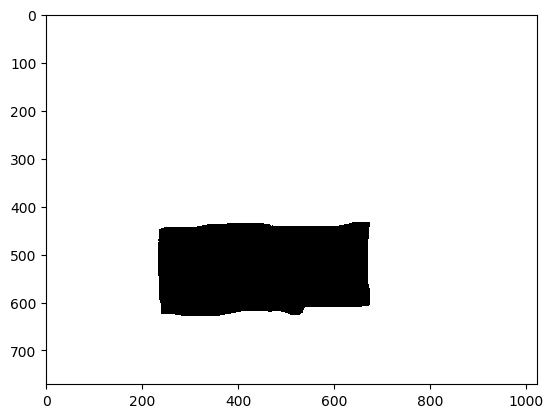

In [138]:
plt.imshow(binaries[28], cmap='gray')

In [139]:
mask_pixels = [np.count_nonzero(~binaries[i]) for i in range(len(binaries))]

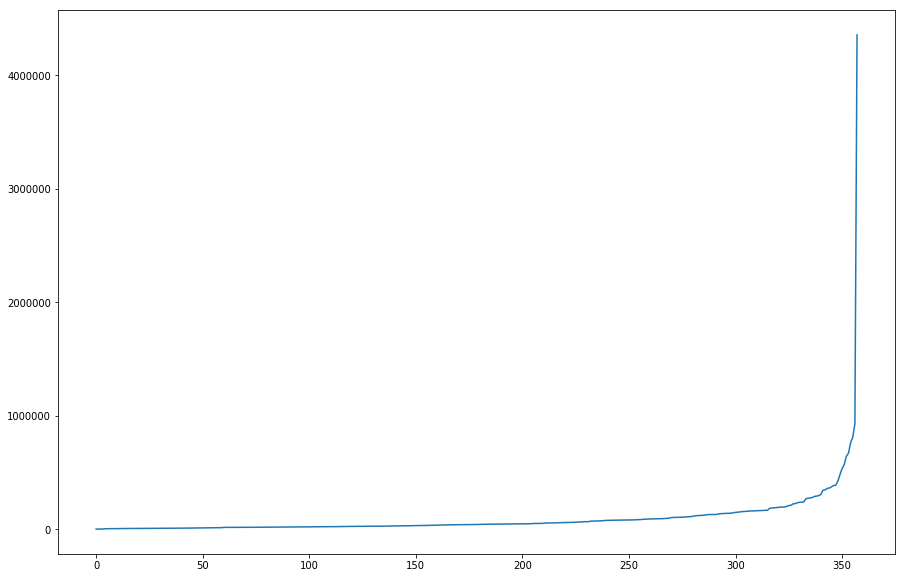

In [109]:
rcParams['figure.figsize']=15,10
plt.plot(sorted(mask_pixels))

In [ ]:
0.25*64*64

In [ ]:
0.4*64*64

In [ ]:
np.percentile(sorted(mask_pixels), np.arange(.1,1,.1))

We must capture information from every image. We use patch size of 64 * 64 and ensuring minimum 40% contribution from forged area and authentic area.<br>This ensures that more than 99% of masks are covered including discriminative boundary at the same time

In [140]:
# def count_255(mask):
#     i=0
#     for row in range(mask.shape[0]):
#         for col in range(mask.shape[1]):
#             if mask[row,col]==255:
#                 i+=1
#     return i

def count_255(mask):
    b = mask
    b[np.where(mask==255)] = 1
    return np.sum(b)

In [141]:
def sample_fake(img, mask):
    kernel_size=64
    stride=32
    
    samples=[]
#     counter =0
    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):
            c_255=count_255(mask[y_start:y_start+kernel_size, x_start:x_start+kernel_size])
            if (c_255>1600) and (kernel_size*kernel_size-c_255>1600):
                samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])    
#         counter += 1
    return samples

In [142]:
sample=sample_fake(x_train_fake_images[5], x_train_masks[5])

In [113]:
len(sample)

3

In [143]:
x_train_fake_images[5].shape

(768, 1024, 3)

In [144]:
x_train_masks[5].shape

(768, 1024)

In [116]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

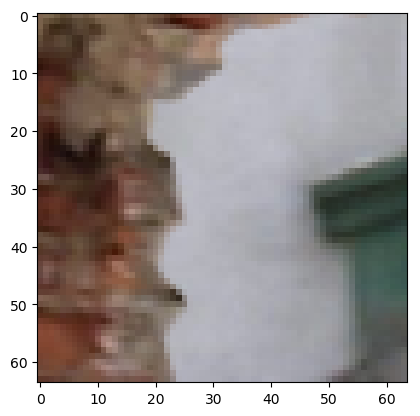

In [117]:
plt.imshow(sample[2])

In [147]:
len(x_train_fake_images)

358

In [148]:
locals()

/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "get_ipython().run_line_magic('ls', '-l')",
  'import tarfile\n\ntar = tarfile.open("phase-01-training.tar.gz", "r:gz")\ntar.extractall()\ntar.close()',
  "get_ipython().run_line_magic('ls', '-l')",
  "import os\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy.misc import imresize\nfrom imageio import imread\nimport shutil\nimport pandas as pd\nimport pickle\nfrom tqdm import tqdm_notebook, tqdm\nfrom sklearn.model_selection import train_test_split\nimport seaborn as sns\nfrom pylab import rcParams\nimport sys\nfrom sklearn.metrics import log_loss, accuracy_score, confusion_matrix\n# import cv2\nget_ipython().run_line_magic('matplotlib', 'inline')",
  "print('Number of fake images = {}'.format((l

In [ ]:
samples_fake=[]
i=0
for fake, mask in zip(x_train_fake_images, x_train_masks):
    image_samples=sample_fake(fake, mask)
    for sample in image_samples:
#         print(sample)
        samples_fake.append(sample)
        i+=1

In [162]:
len(samples_fake)
#k64 grayscale 40percent stride32/sample_fakes_np.npy

1743

In [ ]:
##run above code snippet one at a time and store sample_fakes to sample_fakes_np.npy k64 grayscale 40percent stride32/ and k64 binary 25percent stride8 respectively

Above code is trivially parallelizable, check sample_fake.py and sample_fake_binaries.py

Using kernel size of 64 and stride of 32 produces about 4000 fake samples. Decreasing the stride generates a larger dataset of fake images. We try both stride=32 on grayscale images and stride=8 on binary images.

In [ ]:
samples_fake_grayscale = np.load('k64 grayscale 40percent stride32/sample_fakes_np.npy')
samples_fake_binary = np.load('k64 binary 25percent stride8/sample_fakes_np.npy')

In [ ]:
fake_samples_grayscale = samples_fake_grayscale.shape[0]
fake_samples_binary = samples_fake_binary.shape[0]

In [ ]:
print(f'we have {fake_samples_grayscale} fake samples each of shape 64 * 64 using grayscale masks')
print(f'we have {fake_samples_binary} fake samples each of shape 64 * 64 using binary masks')

In [ ]:
plt.imshow(samples_fake_grayscale[501])

In [ ]:
plt.imshow(samples_fake_binary[120000])

Now to create negative samples we randomly sample 64 * 64 patches from authentic images

In [154]:
def sample_random(img, num_samples, stride=8):
    kernel_size=64
    
    x_start=0
    y_start=0
    samples=[]
    
    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):

            #c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])

            #if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    
    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))
    
    sampled=[]
    for i in indices:
        sampled.append(samples[i])
    
    return sampled

In [ ]:
# some images have all pixels=0 those images have been manually deleted

In [152]:
len(x_train_pristine_images)

819

In [153]:
len(x_train_fake_images)

358

In [159]:
4802/807

5.950433705080545

In [160]:
6*807

4842

In [ ]:
samples_pristine_grayscale=np.ndarray(shape=(4842, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 6, stride=32)
    for sample in samples:
        samples_pristine_grayscale[i, :, :, :]=sample
        i+=1
print(i)

6 samples per pristine image

In [156]:
len(x_train_pristine_images)

819

In [157]:
175609/807

217.6071871127633

In [158]:
217*807

175119

217 samples per pristine image

In [ ]:
samples_pristine_binary=np.ndarray(shape=(175119, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 217)
    for j, sample in enumerate(samples):
        samples_pristine_binary[i, :, :, :]=sample
        i+=1
print(i)

In [ ]:
plt.imshow(samples_pristine_grayscale[4823])

In [ ]:
plt.imshow(samples_pristine_binary[4823])

In [ ]:
print(f'number of fake samples in\n1. binary mask extraction using stride of 8 = {len(samples_fake_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_fake_grayscale)}\n\n\
number of pristine samples in\n1. binary mask extraction using stride of 8 = {len(samples_pristine_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_pristine_grayscale)}')

In [ ]:
train_labels_binary=[0]*len(samples_pristine_binary)+[1]*len(samples_fake_binary)
train_labels_grayscale=[0]*len(samples_pristine_grayscale)+[1]*len(samples_fake_grayscale)

<h4>Checkpoint 2</h4>

x_train, x_test, y_train, y_test, samples_fake, samples_pristine, train_labels, x_train_fake_images, x_train_fakes_names, x_train_images, x_train_mask_names, x_train_masks, x_train_pristine_images, x_train_pristines_names

In [ ]:
np.save('k64 grayscale 40percent stride32/samples_pristine.npy', samples_pristine_grayscale)
np.save('k64 binary 25percent stride8/samples_pristine.npy', samples_pristine_binary)

In [ ]:
with open('data/x_train_fake_images.pickle', 'wb') as f:
    pickle.dump(x_train_fake_images, f)

with open('data/x_train_images.pickle', 'wb') as f:
    pickle.dump(x_train_images, f)
        
with open('data/x_train_pristine_images.pickle', 'wb') as f:
    pickle.dump(x_train_pristine_images, f)

In [ ]:
for i in range(len(x_train_fake_images)):
    with open('data/x_train_fake_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_fake_images[i], f)

In [ ]:
for i in range(len(x_train_images)):
    with open('data/x_train_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_images[i], f)

In [ ]:
for i in range(len(x_train_pristine_images)):
    with open('data/x_train_pristine_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_pristine_images[i], f)

In [ ]:
len(x_train_masks)

In [ ]:
with open('data/x_train_masks.pickle', 'wb') as f:
    pickle.dump(x_train_masks[:50], f)

In [ ]:
with open('data/x_train_masks_1.pickle', 'wb') as f:
    pickle.dump(x_train_masks[50:100], f)

In [ ]:
with open('data/x_train_masks_2.pickle', 'wb') as f:
    pickle.dump(x_train_masks[100:150], f)

In [ ]:
with open('data/x_train_masks_3.pickle', 'wb') as f:
    pickle.dump(x_train_masks[150:200], f)

In [ ]:
with open('data/x_train_masks_4.pickle', 'wb') as f:
    pickle.dump(x_train_masks[200:250], f)

In [ ]:
with open('data/x_train_masks_5.pickle', 'wb') as f:
    pickle.dump(x_train_masks[250:300], f)

In [ ]:
with open('data/x_train_masks_6.pickle', 'wb') as f:
    pickle.dump(x_train_masks[300:350], f)

In [ ]:
with open('data/x_train_masks_7.pickle', 'wb') as f:
    pickle.dump(x_train_masks[350:400], f)

In [ ]:
# with open('x_train.pickle', 'wb') as f:
#     pickle.dump(x_train, f)

# with open('x_test.pickle', 'wb') as f:
#     pickle.dump(x_test, f)
    
# with open('y_train.pickle', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('y_test.pickle', 'wb') as f:
#     pickle.dump(y_test, f)

# with open('samples_fake.pickle', 'wb') as f:
#     pickle.dump(samples_fake, f)

# with open('samples_pristine.pickle', 'wb') as f:
#     pickle.dump(samples_pristine, f)

with open('k64 binary 25percent stride8/train_labels.pickle', 'wb') as f:
    pickle.dump(train_labels_binary, f)
    
with open('k64 grayscale 40percent stride32/train_labels.pickle', 'wb') as f:
    pickle.dump(train_labels_grayscale, f)

with open('x_train_fakes_names.pickle', 'wb') as f:
    pickle.dump(x_train_fakes_names, f)

with open('x_train_mask_names.pickle', 'wb') as f:
    pickle.dump(x_train_mask_names, f)

with open('x_train_pristines_names.pickle', 'wb') as f:
    pickle.dump(x_train_pristines_names, f)

In [ ]:
x_train_masks=[]
for i in range(9):
    with open('data/x_train_masks_'+str(i)+'.pickle', 'rb') as f:
        x_train_masks.extend(pickle.load(f))

In [ ]:
with open('data/x_train_fakes_names.pickle', 'rb') as f:
    x_train_fakes_names=pickle.load(f)
    
x_train_fake_images=[]
for img in x_train_fakes_names:
    x_train_fake_images.append(imread(fake_path+img))

In [ ]:
x_train_pristine_images=[]

with open('data/x_train.pickle', 'rb') as f:
    x_train_pristine_image_names=pickle.load(f)

for name in x_train_pristine_image_names:
    if os.path.isfile(pristine_path+name):
        x_train_pristine_images.append(imread(pristine_path+name))

In [ ]:
samples_pristine_grayscale = np.load('k64 grayscale 40percent stride32/samples_pristine_np.npy')
samples_fake_grayscale = np.load('k64 grayscale 40percent stride32/sample_fakes_np.npy')

with open('k64 grayscale 40percent stride32/train_labels.pickle', 'rb') as f:
    train_labels_grayscale = np.array(pickle.load(f))

In [ ]:
samples_pristine_binary = np.load('k64 binary 25percent stride8/samples_pristine_np.npy')
samples_fake_binary = np.load('k64 binary 25percent stride8/sample_fakes_np.npy')

with open('k64 binary 25percent stride8/train_labels.pickle', 'rb') as f:
    train_labels_binary = np.array(pickle.load(f))

In [ ]:
samples_pristine_grayscale.shape

In [ ]:
samples_fake_grayscale.shape

In [ ]:
train_labels_grayscale.shape

In [ ]:
samples_pristine_binary.shape

In [ ]:
samples_fake_binary.shape

In [ ]:
train_labels_binary.shape

In [ ]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for grayscale sampled images
train_data_grayscale = np.concatenate((samples_pristine_grayscale, samples_fake_grayscale), axis=0)

In [ ]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data_grayscale, train_labels_grayscale, test_size=0.3, stratify = train_labels_grayscale)

In [ ]:
total = len(train_labels_grayscale)*1.
ax=sns.countplot(y_train)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [ ]:
total = len(train_labels_grayscale)*1.
ax=sns.countplot(y_cv)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [ ]:
if not os.path.isdir('k64 grayscale 40percent stride32/train_data'):
    os.mkdir('k64 grayscale 40percent stride32/train_data')
    
    np.save('k64 grayscale 40percent stride32/train_data/x_train.npy', x_train)
    np.save('k64 grayscale 40percent stride32/train_data/x_cv.npy', x_cv)
    
    np.save('k64 grayscale 40percent stride32/train_data/y_train.npy', y_train)
    np.save('k64 grayscale 40percent stride32/train_data/y_cv.npy', y_cv)
else:
    print('train data exists')

In [ ]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for binary sampled images
train_data_binary = np.concatenate((samples_pristine_binary, samples_fake_binary), axis=0)

In [ ]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data_binary, train_labels_binary, test_size=0.3, stratify = train_labels_binary)

In [ ]:
total = len(train_labels_binary)*1.
ax=sns.countplot(y_train)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [ ]:
total = len(train_labels_binary)*1.
ax=sns.countplot(y_cv)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [ ]:
if not os.path.isdir('k64 binary 25percent stride8/train_data2'):
    os.mkdir('k64 binary 25percent stride8/train_data2')
    
    np.save('k64 binary 25percent stride8/train_data2/x_train.npy', x_train)
    np.save('k64 binary 25percent stride8/train_data2/x_cv.npy', x_cv)
    
    np.save('k64 binary 25percent stride8/train_data2/y_train.npy', y_train)
    np.save('k64 binary 25percent stride8/train_data2/y_cv.npy', y_cv)
else:
    print('train data exists')

<h2> 5. Deep learning models </h2>

<h3> 5.1. Random model (worst case performance)</h3>

Our CNN model must give log loss less than 0.89, accuracy more than 49.8%

In [ ]:
# test_len=len(y_cv)
# predicted_y_prob = np.zeros((test_len,2))
# for i in range(test_len):
#     rand_probs = np.random.rand(1,2)
#     predicted_y_prob[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
# print("Log loss on Test Data using Random Model",log_loss(y_cv, predicted_y_prob, eps=1e-15))
# predicted_y =np.argmax(predicted_y_prob, axis=1)
# print("Accuracy on Test Data using Random Model",accuracy_score(y_cv, predicted_y))

# plot_confusion_matrix(y_cv, predicted_y)

<h3> 5.2. CNN architecture</h3>

In [ ]:
import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50

In [ ]:
x_test=np.load('k64 binary 25percent stride8/x_test.npy')

y_test=np.load('k64 binary 25percent stride8/y_test.npy')

#### 5.2.1 VGG16

In [ ]:
# vgg_model=keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

# model_aug=Sequential()
# model_aug.add(vgg_model)

# top_model=Sequential()
# top_model.add(Flatten(input_shape=(2, 2, 512)))
# #model_aug.add(Dropout(0.3))
# top_model.add(Dense(64, activation='relu'))

# top_model.add(Dense(1, activation='sigmoid'))

# model_aug.add(top_model)

# for layer in model_aug.layers[0].layers[:17]:
#     layer.trainable=False
        
# model_aug.load_weights('k64 binary 25percent stride8/remote/hidden/fine_tuned_model_adam_weights.h5')

In [ ]:
# model_aug.summary()

In [ ]:
# model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])

In [ ]:
# model_aug.evaluate(x_test, y_test, verbose=0)

In [ ]:
# y_pred = model_aug.predict_classes(x_test)

In [ ]:
resnet_model=ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model_aug=Sequential()
model_aug.add(resnet_model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))

top_model.add(Dense(64, activation='relu'))
# model_aug.add(Dropout(0.2))

top_model.add(Dense(1, activation='sigmoid'))

model_aug.add(top_model)

for layer in model_aug.layers[0].layers[:171]:
    layer.trainable=False

#### 5.2.2 ResNet50

In [ ]:
model_aug.load_weights('k64 binary 25percent stride8/fine_tuned_model_resnet_64_adam_weights.h5')

model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])

In [ ]:
model_aug.evaluate(x_test, y_test, verbose=0)

In [ ]:
y_pred = model_aug.predict_classes(x_test)

### Once we train and test the model. We save the trained model and deploy ( as rest API) in using Watson Studio

In [ ]:
model_aug.save( "message-classification-model.h5" )
!tar -zcvf message-classification-model.tgz message-classification-model.h5